# Earth angular rotation from StarTrails images

##### Librerie

In [403]:
import sys
import os
from PIL import Image
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd

sys.path.append(os.path.abspath('../lib'))
from SkyImageProcess import SkyImageProcess
from StarsAnalyze import StarsAnalyze
from StarsTracker import StarsTracker
from TrailsAnalyze import TrailsAnalyze
from Utilities import Utilities
import time
import math
from circle_fit import taubinSVD, hyperLSQ, lm, prattSVD
import seaborn as sns
from PIL.ExifTags import TAGS
from datetime import datetime
from scipy.stats import gaussian_kde
from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit

## 1. Estrazione ed elaborazione dati

### 1.1 Estrazione

In [ ]:
data_folder = '../images/21_12_2024/partial_obs_data_2'
output_folder = '../data_for_analysis'
data_code = '21-12-24_partial2'

# parametri
min_magnitude = 0.13
max_magnitude = 1
group = 30
smls_np = 5

filter = 300
src_size = 20

save_name = f'{data_code}_[{min_magnitude}_{max_magnitude}_{group}_{smls_np}]_[{filter}_{src_size}]'

# tracciamento
track = StarsTracker(data_folder, [min_magnitude, max_magnitude, group, smls_np])
data = track.startTracking(filter, src_size)
track.showStarTrakingResult(f'{output_folder}/track_images_out/{save_name}.png')
track.saveData(f'{output_folder}/raw_data', save_name)

### 1.2 Elaborazione

In [392]:
data_save_folder = '../data_for_analysis/processed_data'
data_save_name = f'21-12-24_partial2_[0.13_1_30_5]_[300_20].csv'
save = False
analize_data = pd.read_csv('../data_for_analysis/raw_data/21-12-24_partial2_[0.13_1_30_5]_[300_20].csv')


# estrae tutti gli id delle stelle
star_ids = list(analize_data["id"].unique())

# dataframe con i dati elaborati
processed_data =  pd.DataFrame(columns=["star_id", "trails_center", "radius", "sigma_fit", "start_tracking_time", "end_tracking_time", "T_[h]", "omega_[deg/h]"])


for id in star_ids:
    star_data = analize_data[analize_data['id'] == id]
    # print(list(star_data['timestamp']))

    position_data = [eval(el) for el in star_data['centro']]

    # fit dei dati
    xc, yc, r, sigma = prattSVD(position_data)

    # estrazione tempo iniziale e finale tracciamento
    timestamps = pd.to_datetime(star_data['timestamp'], format='%Y:%m:%d %H:%M:%S')
    start_tracking_time = timestamps.min()
    end_tracking_time = timestamps.max()

    # calcolo periodo
    time_difference = end_tracking_time - start_tracking_time
    periodo = time_difference.total_seconds() / 3600

    # calcolo velocita angolare
    start_pos = eval(list(star_data[star_data['timestamp'] == start_tracking_time.strftime('%Y:%m:%d %H:%M:%S')]['centro'])[0])
    end_pos =   eval(list(star_data[star_data['timestamp'] == end_tracking_time.strftime('%Y:%m:%d %H:%M:%S')]['centro'])[0])


    start_o_dist = (start_pos[0] - xc, start_pos[1] - yc)
    stop_o_dist = (end_pos[0] - xc, end_pos[1] - yc)
    # print(start_o_dist, stop_o_dist)
    cos_t = (start_o_dist[0]*stop_o_dist[0] + start_o_dist[1]*stop_o_dist[1]) / (r**2)
    theta = math.acos(cos_t)
    theta_deg = math.degrees(theta)
    velocita_angolare = theta_deg/periodo


    # inserimento dati su dataframe
    processed_data = pd.concat([
    processed_data,
    pd.DataFrame([{
        "star_id": id,
        "trails_center": (int(xc), int(yc)),
        "radius": r,
        "sigma_fit": sigma,
        "start_tracking_time": start_tracking_time,
        "end_tracking_time": end_tracking_time,
        "T_[h]": periodo, 
        "omega_[deg/h]": velocita_angolare,
    }])
], ignore_index=True)
    

# salva i dati 
if save:
    processed_data.to_csv(f'{data_save_folder}/{data_save_name}')


/var/folders/2_/0sdzrz9514d853_b6lmlm8dc0000gn/T/ipykernel_85552/724454791.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  processed_data = pd.concat([


In [393]:
filter_data = processed_data[processed_data['omega_[deg/h]'] < 13]

# Configurazione per mostrare tutte le righe
pd.set_option('display.max_rows', None)

# Configurazione per mostrare tutte le colonne
pd.set_option('display.max_columns', None)

# Configurazione per non troncare il contenuto delle celle
pd.set_option('display.max_colwidth', None)

filter_data.head(100)
# print(filter_data)

,star_id,trails_center,radius,sigma_fit,start_tracking_time,end_tracking_time,T_[h],omega_[deg/h]
136,fb4a357e-78a4-4724-8ce8-0eb51817bb0e,"(1924, 2977)",1813.655251,0.394197,2024-12-22 01:20:37,2024-12-22 06:14:37,4.9,10.398965


## 2. Analisi Dati

### 2.1. Analisi centro star trails

##### 2.1.1 Statistics indicator 

In [394]:
i_values = [el[0] for el in processed_data['trails_center']]
j_values = [el[1] for el in processed_data['trails_center']]

i_mean = np.mean(i_values)
i_err = np.std(i_values)
j_mean = np.mean(j_values)
j_err = np.std(j_values)


# Centro di Massima Densità (MAP - Maximum A Posteriori)
kde_i = gaussian_kde(i_values)
kde_j = gaussian_kde(j_values)
i_grid = np.linspace(min(i_values), max(i_values), 500)
j_grid = np.linspace(min(j_values), max(j_values), 500)

# Valori del KDE
kde_i_vals = kde_i(i_grid)
kde_j_vals = kde_j(j_grid)

# Trova il massimo della densità
i_map = i_grid[np.argmax(kde_i_vals)]
j_map = j_grid[np.argmax(kde_j_vals)]

print(f"MAP (i, j): ({i_map:.2f}, {j_map:.2f})")


MAP (i, j): (1916.54, 2965.24)


##### 2.1.2 KDE plot

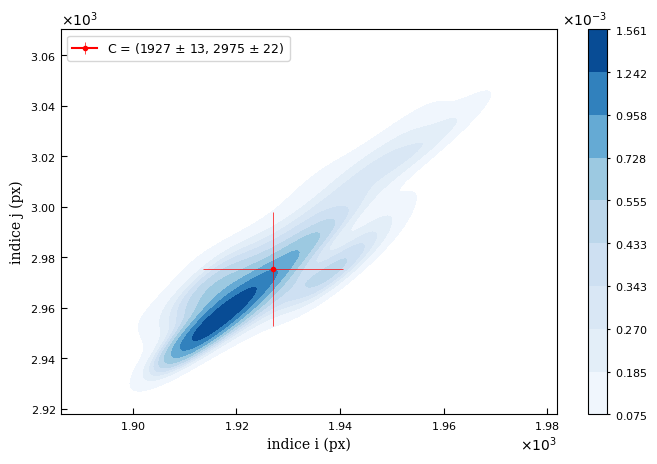

In [526]:
fig, ax = plt.subplots(figsize = (8, 5))
kde = sns.kdeplot(x=i_values, y=j_values, ax=ax,  cmap='Blues', fill=True, label='KDE')
ax.errorbar(i_mean, j_mean, j_err, i_err, color='red', label=f'C = ({int(i_mean)} $\pm$ {int(i_err)}, {int(j_mean)} $\pm$ {int(j_err)})', zorder=10, marker = '.', elinewidth=0.5)
# ax.errorbar(i_map, j_map, color='red', label=f'C = ({int(i_mean)} $\pm$ {int(i_err)}, {int(j_mean)} $\pm$ {int(j_err)})', zorder=10, marker = '.', elinewidth=0.5)
ax.set_xlabel("indice i (px)", fontsize=10, font='Serif')
ax.set_ylabel("indice j (px)", fontsize=10, font='Serif')
# ax.set_title("Centro Star Trails (KDE)", fontsize=9, font='Serif')

ax.tick_params(which='both', direction='in', length=4, labelsize = 8)

#legenda
ax.legend(loc='upper left',  fontsize = 9)

cbar = kde.figure.colorbar(kde.collections[0])  # Ottieni la colorbar
cbar.ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0), useMathText=True)
cbar.ax.tick_params(which='both', length=2, labelsize = 8)

ax.ticklabel_format(axis='both', style='scientific', scilimits=(0,0), useMathText=True)


# ax.grid(True, linestyle = '-', lw=0.4)

##### 2.1.3 Istogramma 2D centro star trails

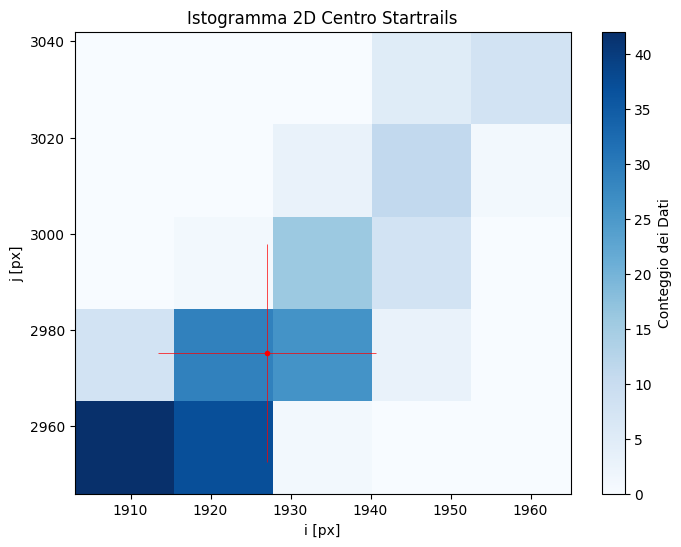

In [207]:
# Istogramma 2D con colorbar
plt.figure(figsize=(8, 6))
counts, xedges, yedges, im = plt.hist2d(i_values, j_values, bins=5, cmap="Blues")
plt.colorbar(label="Conteggio dei Dati")
plt.title("Istogramma 2D Centro Startrails")
plt.xlabel("i [px]")
plt.ylabel("j [px]")
plt.errorbar(i_mean, j_mean, j_err, i_err, color='red', label='Centro', zorder=10, marker = '.', elinewidth=0.5)
plt.show()


##### 2.1.4 Center cordinates distribution plot

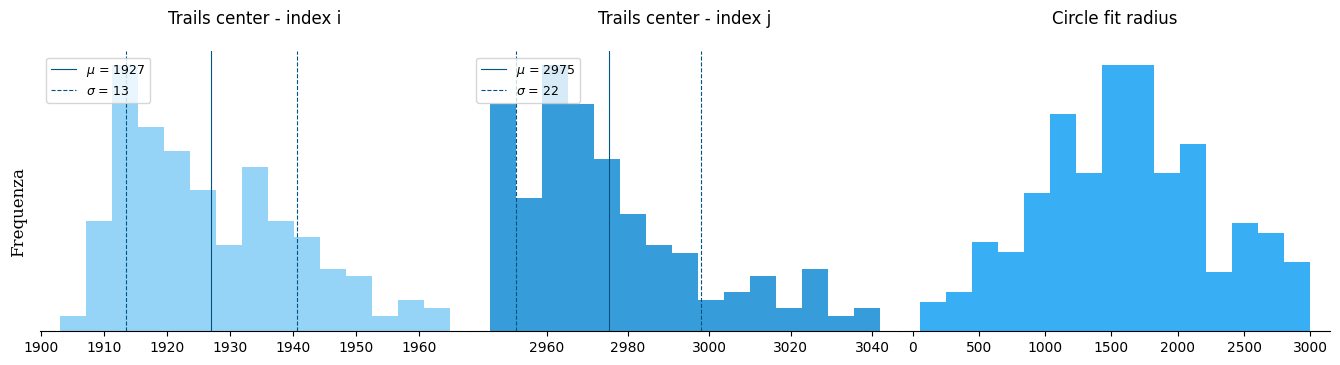

In [208]:
fig, axs = plt.subplots(1, 3)
fig.set_figwidth(15)
fig.set_figheight(4)

plt.subplots_adjust(left=0.04,
                    bottom=0.2, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0, 
                    hspace=0.3)

# img1: distribuzione misura accellerometro asse x
axs[0].hist(i_values, bins=15, alpha=0.8, color='#7bc8f6', density=True)
# axs[0].plot(arr_x, density_x(arr_x))
axs[0].axvline(i_mean, c='#015482', label=f'$\mu$ = {int(i_mean)}', lw=0.8)
axs[0].axvline(i_mean + i_err, c='#015482', linestyle='--', lw=0.8, label=f'$\sigma$ = {int(i_err)}')
axs[0].axvline(i_mean - i_err, c='#015482', linestyle='--', lw=0.8)
axs[0].legend(loc='upper left', fontsize=9)
axs[0].set_title('Trails center - index i', pad=20)
# axs[0].set_xlabel('$a$ [$m/s^2$]', fontsize=12, fontname='Serif', labelpad=10)
# axs[0].set_xticks([0.04, 0.05, 0.06, 0.07])
axs[0].set_yticks([])

# img2 distrubuzione accellerazione ass3e y
axs[1].hist(j_values, bins=15, alpha=0.8, color='#0485d1')
# axs[1].plot(arr_y, density_y(arr_y))
axs[1].axvline(j_mean, c='#015482', label=f'$\mu$ = {int(j_mean)}', lw=0.8)
axs[1].axvline(j_mean + j_err, c='#015482', linestyle='--', lw=0.8, label=f'$\sigma$ = {int(j_err)}')
axs[1].axvline(j_mean - j_err, c='#015482', linestyle='--', lw=0.8)
axs[1].legend(loc='upper left', fontsize=9)
axs[1].set_title('Trails center - index j', pad=20)
# axs[1].set_xlabel('$a$ [$m/s^2$]', fontsize=12, fontname='Serif', labelpad=10)
# axs[1].set_xticks([0.03, 0.04, 0.05, 0.06])
axs[1].set_yticks([])


# img3 distrubuzione raggi 
axs[2].hist(processed_data['radius'], bins=15, alpha=0.8, color='#069af3')
axs[2].set_title('Circle fit radius', pad=20)
axs[2].set_yticks([])

# axs[2].hist2d(circle_centers_i, circle_centers_j, bins=[20, 20], alpha=0.8, cmap='viridis')
# axs[2].set_title('Circle fit radius', pad=20)
# fig.colorbar(axs[2])
# axs[2].set_yticks([])


############# impostazioni generali figura
fig.supylabel('Frequenza', fontsize=12, fontname='Serif')

# rimozione bordi figure
for i in range(3):
    for direction in ['right', 'top', 'left']:
        axs[i].spines[direction].set_visible(False)

### 2.2 Distribuzione velocita angolare plot

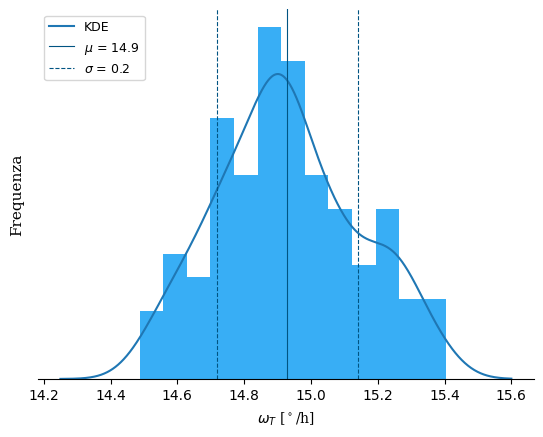

In [498]:
data_plot = processed_data[processed_data['omega_[deg/h]'] > 13]['omega_[deg/h]']

# Calcolo KDE
kde = gaussian_kde(data_plot)
x_grid = np.linspace(14.25, 15.60, 1000)
kde_vals = kde(x_grid)

omega_mean = np.mean(data_plot)
omega_std = np.std(data_plot)

fig, ax = plt.subplots()

ax.plot(x_grid, kde_vals, label='KDE')
ax.hist(data_plot, bins=13, alpha=0.8, color='#069af3', density=True)
ax.axvline(omega_mean, c='#015482', label=f'$\mu$ = {round(omega_mean, 1)}', lw=0.8)
ax.axvline(omega_mean + omega_std, c='#015482', linestyle='--', lw=0.8, label=f'$\sigma$ = {round(omega_std, 1)}')
ax.axvline(omega_mean - omega_std, c='#015482', linestyle='--', lw=0.8)
ax.legend(loc='upper left', fontsize=9)
# ax.set_title('Velocita angolare rotazione terrestre', pad=20)
ax.set_xlabel('$\omega_T$ [$^\circ$/h]', fontsize=10, fontname='Serif', labelpad=5)
ax.set_ylabel('Frequenza', fontsize=11, fontname='Serif', labelpad=10)
ax.set_yticks([])


# rimozione bordi figure
for direction in ['right', 'top', 'left']:
    ax.spines[direction].set_visible(False)



## 3. Test algoritmo tracciamento

Il seguente script serve a confrontare la posizione della stella al tempo t con quella teorica

### 3.1 Confronto posizione tracciata con posizione teorica

In [430]:
raw_data_folder = '../data_for_analysis/raw_data'
processed_data_folder = '../data_for_analysis/processed_data'
file_name = '21-12-24_partial2_[0.13_1_30_5]_[300_20].csv'


def errMedio(raw_data_f, processed_data_f, f_name, xc, yc):
    raw_data = pd.read_csv(f'{raw_data_folder}/{file_name}')
    processed_data = pd.read_csv(f'{processed_data_folder}/{file_name}')

    # estrae tutti gli id delle stelle
    star_ids = list(processed_data["star_id"].unique())

    # array che contiene l'errore medio per ogni stella
    stars_sigma_m = []
    stars_sigma_m_err = []
    rad = []

    for id in star_ids:

        # informazioni iniziali
        star_data = raw_data[raw_data['id'] == id].sort_values(by='immagine')

        r = int(processed_data[processed_data['star_id'] == id].iloc[0]['radius'])
        start_time = processed_data[processed_data['star_id'] == id].iloc[0]['start_tracking_time']
        omega_deg_s = (2*np.pi)/86164


        # angolo iniziale
        first_raw = star_data.iloc[0]
        start_coord = eval(first_raw['centro'])
        Dx = start_coord[0] - xc
        Dy = start_coord[1] - yc
        start_angle_deg = math.atan2(Dy, Dx)

        # print('start coord:', start_coord)

        errors_model = []
        # calcola l'errore di tracciamento
        for index, row in star_data.iterrows():
            if index == 0:
                continue

            pos = eval(row['centro'])
            date_time = row['timestamp']
            T_s = (datetime.strptime(date_time, "%Y:%m:%d %H:%M:%S") - datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S")).total_seconds()
            
            # posizione teorica
            x_teo = xc + r*np.cos(omega_deg_s * T_s + start_angle_deg) 
            y_teo = yc + r*np.sin(omega_deg_s * T_s + start_angle_deg) 

            # print(pos)
            # print(int(x_teo), int(y_teo))

            d = (pos[0] - x_teo, pos[1] - y_teo)

            # calcolo distanza posizione teorica e misurata
            dist = np.linalg.norm(d)
            errors_model.append(dist)

        if abs(np.mean(errors_model)) < 100:
            stars_sigma_m.append(np.mean(errors_model))
            stars_sigma_m_err.append(np.std(errors_model))
            rad.append(r)

    return stars_sigma_m, stars_sigma_m_err, rad

# (1916.54, 2965.24)

stars_sigma_m, stars_sigma_m_err, rad = errMedio(raw_data_folder, processed_data_folder, file_name, 1927, 2975)
stars_sigma_m1, stars_sigma_m_err1, rad1 = errMedio(raw_data_folder, processed_data_folder, file_name, 1914, 2953)



In [ ]:
# Funzione obiettivo per calcolare l'errore globale
def errore_globale(center):
    xc, yc = center
    stars_sigma_m, _, _ = errMedio(raw_data_folder, processed_data_folder, file_name, xc, yc)
    return np.mean(stars_sigma_m)

# Intervalli di ricerca basati su media e deviazione standard
xc_mean, xc_std = 1927, 13  
yc_mean, yc_std = 2975, 22
bounds = [(xc_mean - xc_std, xc_mean + xc_std), (yc_mean - yc_std, yc_mean + yc_std)]

# Generazione di una griglia di centri
xc_values = np.linspace(bounds[0][0], bounds[0][1], 10)
yc_values = np.linspace(bounds[1][0], bounds[1][1], 10)
xc_grid, yc_grid = np.meshgrid(xc_values, yc_values)

# Calcolo dell'errore globale per ogni punto della griglia
error_map = np.zeros_like(xc_grid)
for i in range(xc_grid.shape[0]):
    for j in range(xc_grid.shape[1]):
        center = [xc_grid[i, j], yc_grid[i, j]]
        error_map[i, j] = errore_globale(center)


# Ottimizzazione per trovare il centro che minimizza l'errore globale
initial_guess = [xc_mean, yc_mean]
result = minimize(errore_globale, initial_guess, method='L-BFGS-B', bounds=bounds)
optimal_xc, optimal_yc = result.x

print(f"Centro ottimale: xc = {optimal_xc:.2f}, yc = {optimal_yc:.2f}")


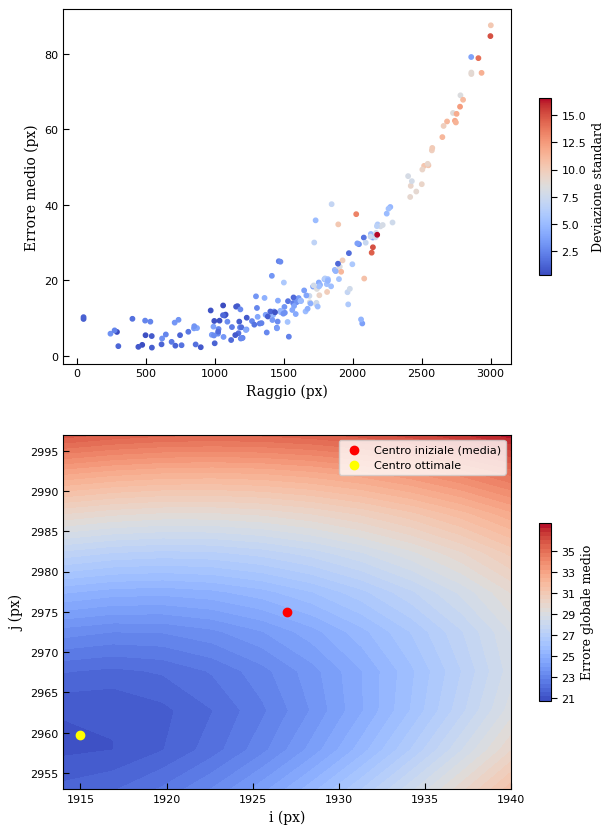

In [522]:
fig, ax = plt.subplots(2,1, figsize=(8, 12))

# fig.suptitle('Errori medi con deviazione standard', fontsize=12, fontname='Serif', x=0.36)
# fig.supylabel('Errore medio (px)')
# fig.colorbar()

plt.subplots_adjust(left=0.08,
                    bottom=0.2, 
                    right=0.78, 
                    top=0.85, 
                    wspace=0.08, 
                    hspace=0.2)

scatter = ax[0].scatter(rad1, stars_sigma_m1, c=stars_sigma_m_err1, cmap='coolwarm', s=10)
cbar = plt.colorbar(scatter, shrink=0.5, aspect=15, location='right', pad = 0.05)
cbar.set_label('Deviazione standard', fontsize=9, fontname='Serif')
cbar.ax.tick_params(length=4, labelsize = 8)


ax[0].set_xlabel('Raggio (px)', fontsize=10, fontname='Serif')
ax[0].set_ylabel('Errore medio (px)', fontsize=10, fontname='Serif')
# ax[0].set_title('$C_\mu$', fontsize=12, fontname='Serif')
ax[0].tick_params(which='both', direction='in', length=4, labelsize = 8)
# ax[0].set_title('Errore medio', fontsize=10, fontname='Serif')


scatter2 = ax[1].contourf(xc_grid, yc_grid, error_map, levels=50, cmap="coolwarm")
# plt.colorbar(label="Errore globale medio")
ax[1].scatter(xc_mean, yc_mean, color="red", label="Centro iniziale (media)")
ax[1].scatter(optimal_xc, optimal_yc, color="yellow", label="Centro ottimale")
cbar2 = plt.colorbar(scatter2, shrink=0.5, aspect=15, location='right', pad = 0.05)
cbar2.set_label('Errore globale medio', fontsize=9, fontname='Serif')
cbar2.ax.tick_params(length=4, labelsize = 8)
cbar2.ax.set_yticks([21, 23, 25, 27, 29, 31, 33, 35])
ax[1].set_xlabel('i (px)', fontsize=10, fontname='Serif')
ax[1].set_ylabel('j (px)', fontsize=10, fontname='Serif')
# ax[1].set_title('Errore globale medio', fontsize=10, fontname='Serif')
ax[1].tick_params(which='both', direction='in', length=4, labelsize = 8)
ax[1].legend(fontsize=8)


### 3.2 Analisi tempo computazionale

In [400]:
images_data_test = pd.read_csv('../data_for_analysis/speed_test_data/times_images.csv')
stars_data_test = pd.read_csv('../data_for_analysis/speed_test_data/times_stars.csv')
images_data_test.head(20)

n_images = images_data_test['numero_immagini']
speed = images_data_test['velocita_elaborazione']
speed_err = images_data_test['errore_vel_el']

n_stars = stars_data_test['numero_stelle']
speed_stars = stars_data_test['velocita_elaborazione']
speed_stars_err = stars_data_test['errore_vel_el']

In [402]:
# funzioni modello per il fit

def linear_f(x, m, q):
    return m*x + q

def power_f(x, a, c, n):
    return a*x**n + c

In [412]:
# fit dei dati
parms, covm = curve_fit(power_f, n_images, speed)
print(parms)
xx1 = np.linspace(min(n_images), max(n_images), 2000)


speed_stars_test = [el - 36 for el in speed_stars]
parms2, covm2 = curve_fit(power_f, n_stars, speed_stars, sigma = speed_stars_err, absolute_sigma=False)
print(parms2)
xx2 = np.linspace(0, max(n_stars), 2000)

[ 0.15043046 -0.12520247  1.18506251]
[1.10251510e-02 3.61958199e+01 1.49749728e+00]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


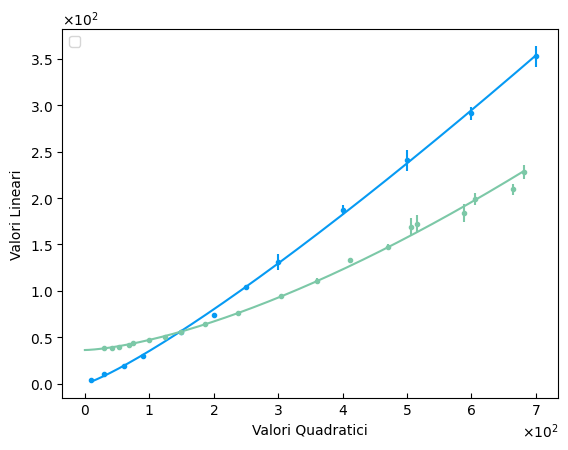

In [413]:
fig, ax1 = plt.subplots()

ax1.errorbar(n_images, speed, speed_err, ls = '', marker = '.', color='#069af3')
ax1.plot(xx1, power_f(xx1, *parms), color='#069af3')
ax1.set_xlabel("Numero immagini")
ax1.set_ylabel("Valori Lineari")
ax1.tick_params(axis='x', tickdir="in")
ax1.ticklabel_format(axis='both', style='scientific', scilimits=(0,0), useMathText=True)
ax1.legend(loc="upper left")
# ax1.set_yscale('log')
# ax1.set_xscale('log')


# ax2 = ax1.twinx()
ax1.errorbar(n_stars, speed_stars, speed_stars_err, ls = '', marker = '.', color='#7CC8A7')
ax1.plot(xx2, power_f(xx2, *parms2), color='#7CC8A7')
ax1.set_xlabel("Valori Quadratici")
ax1.tick_params(axis='x', tickdir="in")
ax1.legend(loc="upper left")
ax1.ticklabel_format(axis='x', style='scientific', scilimits=(0,0), useMathText=True)